# Library

In [4]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof
# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

# AsynmetricLoss

In [5]:

class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        x_sigmoid = torch.sigmoid(x)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


# Focal Loss

In [6]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

# Dataset

In [7]:
root_dataset_path = "/content/drive/MyDrive/DOA/SNS/400/DOA4"

In [8]:
def create_dataset(df, dataset_type):
  
    data = np.transpose(df[dataset_type], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [9]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(train, test)
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader

In [10]:
def create_dataloader(root_path, dataset_type, ss):
  # Loading all dataset 
  logging.info('Data prepration started')
  df1  = sio.loadmat(root_path + "/SNR_SNS_00_4_400.mat")
  df2  = sio.loadmat(root_path + "/SNR_SNS_10_4_400.mat")
  df3  = sio.loadmat(root_path + "/SNR_SNS_20_4_400.mat")
  df4  = sio.loadmat(root_path + "/SNR_SNS_30_4_400.mat")
  df5  = sio.loadmat(root_path + "/SNR_SNS_40_4_400.mat")
  df = [df1, df2, df3, df4, df5]

  new_train_dataset_list = []
  new_test_dataset_list = []
  train_dataset_list_label = []
  test_dataset_list_label = []

  dataset_len = 0
  if dataset_type == "SNS":
    dataset_len = ss//10
  if dataset_type == "NS":
    dataset_len = ss

  for file in df:
    X_train, X_test, y_train, y_test = create_dataset(file, dataset_type+"_data")
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())

  # Deleteing all unused memory
  del df

  # Dividing into different channels
  logging.info('Dividing your dataset into 3 channel')
  
  for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, dataset_len))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new

  for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, dataset_len))
        for j in range(0, 8):
            for k in range(0, dataset_len):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

  # Generaring train loader
  logging.info('Creating Train dataloader')
  doa_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

  # Deleteing all unused memory
  del new_train_dataset_list
  del train_dataset_list_label

  test_dataset_list = []
  logging.info('Creating Validation dataloader')
  for idx, data in enumerate(new_test_dataset_list):
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)
  
  # Deleteing all unused memory
  del new_test_dataset_list
  del new
  logging.info('Your dataset is ready !!')
  return doa_train_loader ,test_dataset_list

In [ ]:
doa_train_loader , test_dataset_list = create_dataloader(root_dataset_path, "SNS", 400)

2021-06-25 10:34:30,344 - Data prepration started
2021-06-25 10:35:25,004 - Dividing your dataset into 3 channel
2021-06-25 10:42:50,868 - Creating Train dataloader
2021-06-25 10:42:54,996 - Creating Validation dataloader
2021-06-25 10:42:57,946 - Your dataset is ready !!


# Model(Resnet)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        self.adp_pool = nn.AdaptiveMaxPool2d((4, 25))
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.dropout = nn.Dropout(0.7)
        self.dropout1 = nn.Dropout(0.6)
        self.relu = nn.ReLU(inplace=True)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # print("Input ==> ", x.size())
        out = self.relu(self.bn1(self.conv1(x)))
        # print("F.relu(self.bn1(self.conv1(x))) ==> ", x.size())
        out = self.layer1(out)
        # print("layer1 ==> ", x.size())
        out = self.layer2(out)
        # print("layer2 ==> ", x.size())
        out = self.layer3(out)
        # print("layer3 ==> ", x.size())
        out = self.dropout(out)
        out = self.layer4(out)
        out = self.dropout1(out)
#         print("layer4 ==>", out.size())
        out = self.adp_pool(out)
        
#         print("avg_pool2d ===>", out.size())
        # out = out.view(out.size(0), -1)
        # print("out.view ===>", out.size())
        out = self.linear(out)
        out = self.dropout1(out)
        out = self.flat(out)
#         print("Out ===>", out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [2, 3, 5, 2])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 10, 100)
    model = ResNet34()
    model(image)


# Training 

In [ ]:
num_epochs = 30
doa = 4
weights_dir = "/content/drive/MyDrive/DOA/SNS/400"

autoencoder = ResNet34()
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss()
# criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
# if ('SNS_DOA_{}_model.pth'.format(doa) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
#     print("Pre-trained available for DOA_{}_model.pth".format(doa))
#     autoencoder = torch.load(os.path.join(weights_dir, 'SNS_DOA_{}_model.pth'.format(doa)))

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = autoencoder.cuda()
	optimizer = optim.AdamW(classification_model.parameters(), lr=0.0001, weight_decay=1e-5)
	criterion = criterion.cuda()

Tesla P100-PCIE-16GB


In [ ]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
mae_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [ ]:
from sklearn.preprocessing import label_binarize


In [ ]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, doa))
            # print(auto_outputs[0])
            # print(labels[0])
            # labels = label_binarize([172,  40,  97, 144], classes=[i for i in range(0, 181)])
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(64*len(doa_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa_train_loader)*64*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, doa))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                
                mae_res[10*val_data].append(validation_mae/(128*len(test_dataset_list[val_data])*181))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*128*181)))

                total_valdation_loss+=validation_loss
            torch.save( classification_model, weights_dir+ "/SNS_DOA_{}_400_model_floss.pth".format(doa))
            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( classification_model, weights_dir+ "/DOA_{}_400_best_model_floss.pth".format(doa))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/30], Training Loss: 5.0456, Training Accuracy: 0.8041, Training MAE: 1.237332064082075
SNR [0dB], Validation Loss: 4.5264, Validation Accuracy: 2.3683, Validation MAE: 0.7100025458844461
SNR [10dB], Validation Loss: 4.2212, Validation Accuracy: 3.3717, Validation MAE: 0.5419397883696976
SNR [20dB], Validation Loss: 4.1543, Validation Accuracy: 3.5500, Validation MAE: 0.5045024844320629
SNR [30dB], Validation Loss: 4.1450, Validation Accuracy: 3.4667, Validation MAE: 0.5048503488154321
SNR [40dB], Validation Loss: 4.1464, Validation Accuracy: 3.4067, Validation MAE: 0.508072941052533


Epoch [2/30], Training Loss: 2.7454, Training Accuracy: 13.0212, Training MAE: 0.22258284173071852
SNR [0dB], Validation Loss: 3.5934, Validation Accuracy: 10.4583, Validation MAE: 0.36552462777413613
SNR [10dB], Validation Loss: 2.5039, Validation Accuracy: 21.9950, Validation MAE: 0.1327744580485064
SNR [20dB], Validation Loss: 2.1279, Validation Accuracy: 27.6383, Valid

In [ ]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, doa))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))
        mae_res['training'].append(training_mae/(64*len(doa_train_loader)*181))
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa_train_loader), (100*(train_correct/train_total)), training_mae/(len(doa_train_loader)*64*181)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, doa))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                
                mae_res[10*val_data].append(validation_mae/(128*len(test_dataset_list[val_data])*181))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/(len(test_dataset_list[val_data])*128*181)))

                total_valdation_loss+=validation_loss
            torch.save( classification_model, weights_dir+ "/SNS_DOA_{}_400_model.pth".format(doa))
            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( classification_model, weights_dir+ "/DOA_{}_400_best_model.pth".format(doa))
#         if i%10 == 0:
#           ddf = pd.DataFrame(acc_res)
#           ddf.to_csv(weights_dir+"res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/30], Training Loss: 4.5342, Training Accuracy: 2.9311, Training MAE: 0.9418875065410671
SNR [0dB], Validation Loss: 3.8180, Validation Accuracy: 6.4117, Validation MAE: 0.3885411057917408
SNR [10dB], Validation Loss: 3.1404, Validation Accuracy: 11.5067, Validation MAE: 0.172897011658395
SNR [20dB], Validation Loss: 2.9755, Validation Accuracy: 13.0200, Validation MAE: 0.13625932027811594
SNR [30dB], Validation Loss: 2.9523, Validation Accuracy: 13.0933, Validation MAE: 0.13359894418953086
SNR [40dB], Validation Loss: 2.9497, Validation Accuracy: 13.2133, Validation MAE: 0.13272873454911507


Epoch [2/30], Training Loss: 2.6329, Training Accuracy: 17.5393, Training MAE: 0.16519201047652246
SNR [0dB], Validation Loss: 3.4847, Validation Accuracy: 10.7167, Validation MAE: 0.35537108460530015
SNR [10dB], Validation Loss: 2.4411, Validation Accuracy: 22.1850, Validation MAE: 0.13347347890720104
SNR [20dB], Validation Loss: 2.0660, Validation Accuracy: 28.52

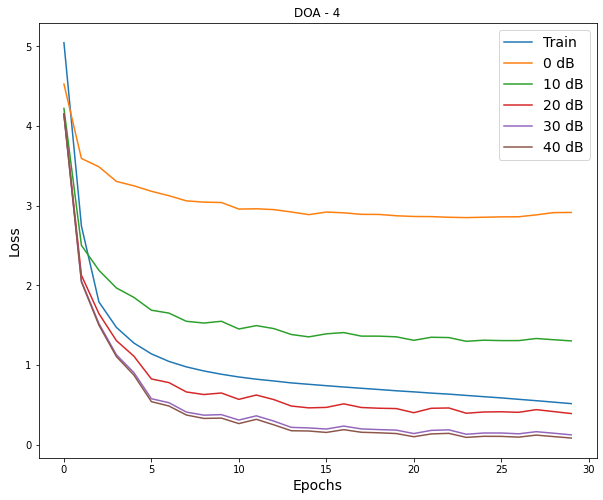

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - 4")
plt.legend(fontsize=14)
# plt.savefig("DOA3_resnet34")
plt.show()

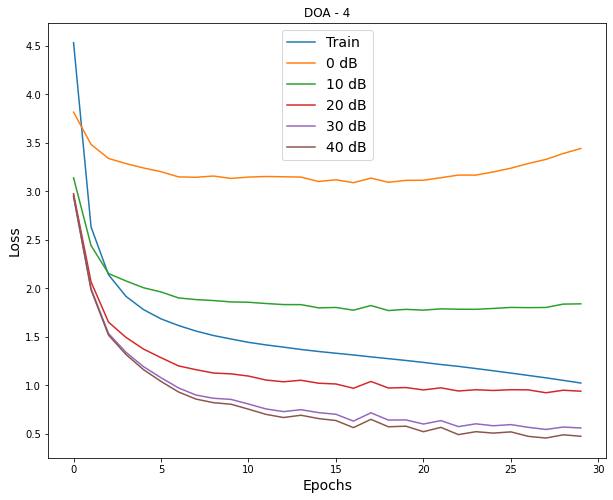

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - 4")
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

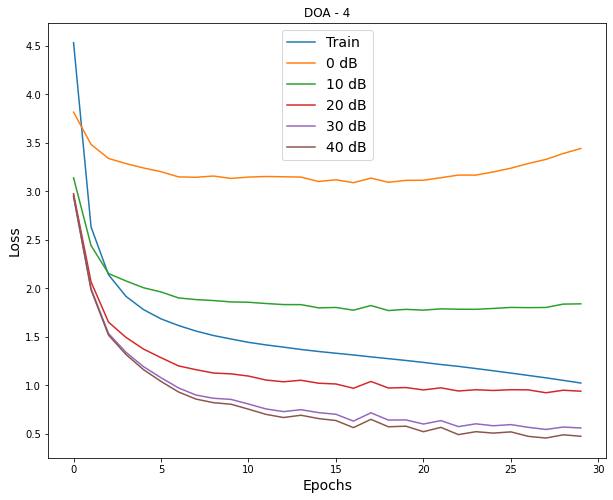

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, len(loss_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(doa))
plt.legend(fontsize=14)
plt.show()

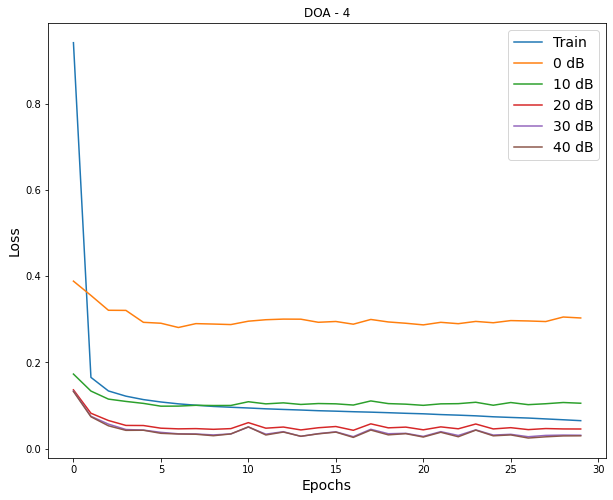

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, len(mae_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, mae_res["training"], label='Train')
plt.plot(ep, mae_res[0], label='0 dB')
plt.plot(ep, mae_res[10], label='10 dB')
plt.plot(ep, mae_res[20], label='20 dB')
plt.plot(ep, mae_res[30], label='30 dB')
plt.plot(ep, mae_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(doa))
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

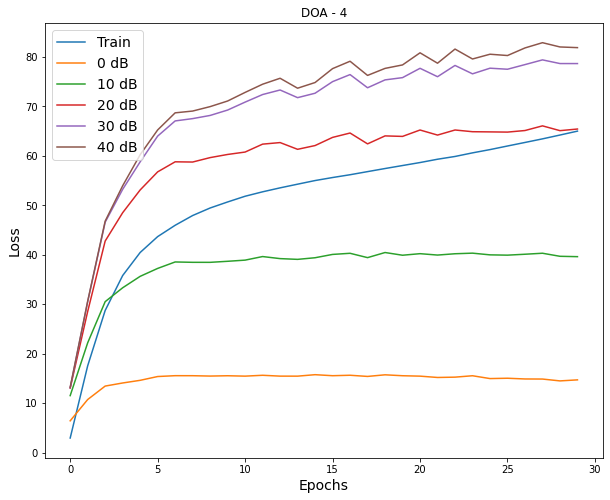

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, len(acc_res["training"]))
plt.figure(figsize=(10, 8))
plt.plot(ep, acc_res["training"], label='Train')
plt.plot(ep, acc_res[0], label='0 dB')
plt.plot(ep, acc_res[10], label='10 dB')
plt.plot(ep, acc_res[20], label='20 dB')
plt.plot(ep, acc_res[30], label='30 dB')
plt.plot(ep, acc_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("DOA - {}".format(doa))
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

In [ ]:
print(max(acc_res[0]), max(acc_res[10]), max(acc_res[20]), max(acc_res[30]), max(acc_res[40]))
print(min(mae_res[0]), min(mae_res[10]), min(mae_res[20]), min(mae_res[30]), min(mae_res[40]))

92.04333333333334 30.47666666666667 90.48333333333333 83.29333333333334 62.11666666666667
0.010949863634235415 0.09295441111059088 0.012185861269781814 0.017014994381496396 0.03619143002621968


In [ ]:
mae_res[0].index(min(mae_res[0]))

26

In [ ]:
print("=== Metrics ===")
print("==== DOA-{} ====".format(doa))
print("= MAE =_= Acc =")
print("{:.4f}".format(min(mae_res[0])), "  {:.2f}".format(acc_res[0][mae_res[0].index(min(mae_res[0]))]))
print("{:.4f}".format(min(mae_res[10])), "  {:.2f}".format(acc_res[10][mae_res[10].index(min(mae_res[10]))]))
print("{:.4f}".format(min(mae_res[20])), "  {:.2f}".format(acc_res[20][mae_res[20].index(min(mae_res[20]))]))
print("{:.4f}".format(min(mae_res[30])), "  {:.2f}".format(acc_res[30][mae_res[30].index(min(mae_res[30]))]))
print("{:.4f}".format(min(mae_res[40])), "  {:.2f}".format(acc_res[40][mae_res[40].index(min(mae_res[40]))]))

=== Metrics ===
==== DOA-2 ====
= MAE =_= Acc =
0.0109   91.85
0.0930   29.55
0.0122   90.48
0.0170   83.11
0.0362   60.66


In [ ]:
print("=== Metrics ===")
print("==== DOA-{} ====".format(doa))
print("= MAE =_= Acc =")
print("{:.4f}".format(min(mae_res[0])), "  {:.2f}".format(acc_res[0][mae_res[0].index(min(mae_res[0]))]))
print("{:.4f}".format(min(mae_res[10])), "  {:.2f}".format(acc_res[10][mae_res[10].index(min(mae_res[10]))]))
print("{:.4f}".format(min(mae_res[20])), "  {:.2f}".format(acc_res[20][mae_res[20].index(min(mae_res[20]))]))
print("{:.4f}".format(min(mae_res[30])), "  {:.2f}".format(acc_res[30][mae_res[30].index(min(mae_res[30]))]))
print("{:.4f}".format(min(mae_res[40])), "  {:.2f}".format(acc_res[40][mae_res[40].index(min(mae_res[40]))]))

=== Metrics ===
==== DOA-4 ====
= MAE =_= Acc =
0.2810   15.54
0.0984   37.23
0.0424   64.61
0.0275   78.45
0.0244   81.82


In [ ]:
print("=== Metrics ===")
print("==== DOA-{} ====".format(doa))
print("= MAE =_= Acc =")
print("{:.4f}".format(min(mae_res[0])), "  {:.2f}".format(acc_res[0][mae_res[0].index(min(mae_res[0]))]))
print("{:.4f}".format(min(mae_res[10])), "  {:.2f}".format(acc_res[10][mae_res[10].index(min(mae_res[10]))]))
print("{:.4f}".format(min(mae_res[20])), "  {:.2f}".format(acc_res[20][mae_res[20].index(min(mae_res[20]))]))
print("{:.4f}".format(min(mae_res[30])), "  {:.2f}".format(acc_res[30][mae_res[30].index(min(mae_res[30]))]))
print("{:.4f}".format(min(mae_res[40])), "  {:.2f}".format(acc_res[40][mae_res[40].index(min(mae_res[40]))]))

=== Metrics ===
==== DOA-4 ====
= MAE =_= Acc =
0.3212   14.86
0.1062   40.06
0.0415   65.80
0.0247   77.25
0.0216   80.36
